In [ ]:
!pip3 install umap-learn
from collections import Counter

import pickle
import sklearn.metrics
import sklearn.preprocessing
import sklearn.neighbors
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_curve, RocCurveDisplay, accuracy_score
import numpy as np
from umap import UMAP
from scipy.stats import ttest_rel
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 22.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=46f2f2b129a1fb5fe6242ab3958f120693dc5ead61868a83038f46d43ef91c5c
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=1b9f9bbe7635a6f581df1b22ab6bc17a64d3a4c6e7703f2293d725abaeda10ec
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


## 1. Reading data

In [ ]:
#unpickle and read data

def load_pkl(fn):
    with open(fn,"br") as f:
        return pickle.load(f)

#load acoustic formant features:
train_f = load_pkl("f-train-1")
dev_f = load_pkl("f-dev-2")
test_f = load_pkl("f-test-2")

#load hubert features:
train_hb = load_pkl("hb-train-1")
dev_hb = load_pkl("hb-dev-2")
test_hb = load_pkl("hb-test-2")

In [ ]:
print(train_hb[0])
print(train_f[0])
print(len(train_hb))
print(len(train_f))
print(len(dev_f))
print(len(test_hb))

{'filename': 'mn_tw_8_rs_rang4_118.0914', 'speaker': 'mn_tw_8', 'gender': 'm', 'speech_rate': '6.666666666666414', 'word': 'rang4', 'phone': 'a', 'previous': 'r', 'following': 'ng', 'midpoint': 65.00000000000483, 'hid': [0.37560147047042847, 0.02747984416782856, 0.18099084496498108, 0.061432842165231705, -0.490862637758255, -0.02007347159087658, 0.2104063183069229, -0.14300405979156494, 0.3390335440635681, 0.2802048623561859, 0.019439561292529106, 0.08007252216339111, 0.18567152321338654, -0.17506814002990723, 0.032682083547115326, -0.05131269618868828, 0.043615005910396576, 0.30057865381240845, 0.44626519083976746, -0.1027735248208046, 0.44790902733802795, 0.02428428642451763, -0.16654159128665924, -0.33041462302207947, -0.2751398980617523, 0.31357645988464355, -0.9800292253494263, 0.4118482768535614, -0.5114543437957764, 0.5156916975975037, -0.09819887578487396, 0.16000975668430328, 0.3789534866809845, -0.0734037533402443, -0.10322023928165436, -0.1228988841176033, -0.283692032098770

## 2. Encoding labels and features

In [ ]:
#Encode labels for each data point for acoustic features:
#initialize the label encoder
label_encoder_f = sklearn.preprocessing.LabelEncoder()

train_f_labels = [ex["following"] for ex in train_f]
dev_f_labels = [ex["following"] for ex in dev_f]
test_f_labels = [ex["following"] for ex in test_f]

#call fit() to train the label encoder
label_encoder_f.fit(train_f_labels + dev_f_labels + test_f_labels)
print(train_f_labels)

#define a function that takes a dataset and the label encoder, and returns a list of feature values and the labels
def get_input_and_output_f(data, label_encoder_f):
  X = [] #tuples of F1 and F2 features
  y = [] #gold-standard class
  

  for ex in data:
    f1 = float(ex["F1"])
    f2 = float(ex["F2"])
    f3 = float(ex["F3"])
    X.append((f1, f2, f3))
    #trainsform the vowel class to number and add it to the label list
    y.extend(label_encoder_f.transform([ex["following"]]))

  return X, y

#store the feature values and label for each example of train, dev and test in the following lists
train_f_X, train_f_y = get_input_and_output_f(train_f, label_encoder_f)
dev_f_X, dev_f_y = get_input_and_output_f(dev_f, label_encoder_f)
test_f_X, test_f_y = get_input_and_output_f(test_f, label_encoder_f)

print(train_f_X[0])
print(train_f_y[0])
print(dev_f_X[0])
print(label_encoder_f.classes_)

['ng', 'n', 'ng', 'n', 'ng', 'ng', 'n', 'ng', 'n', 'n', 'n', 'n', 'ng', 'ng', 'ng', 'n', 'n', 'n', 'n', 'n', 'n', 'ng', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'ng', 'ng', 'ng', 'n', 'n', 'n', 'ng', 'ng', 'ng', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'ng', 'n', 'n', 'ng', 'n', 'n', 'n', 'n', 'n', 'n', 'ng', 'n', 'ng', 'n', 'ng', 'n', 'ng', 'n', 'n', 'ng', 'n', 'ng', 'ng', 'n', 'ng', 'n', 'ng', 'ng', 'n', 'n', 'ng', 'n', 'n', 'n', 'ng', 'n', 'n', 'ng', 'n', 'ng', 'ng', 'n', 'ng', 'ng', 'ng', 'ng', 'n', 'n', 'ng', 'n', 'n', 'ng', 'n', 'ng', 'n', 'ng', 'ng', 'n', 'ng', 'n', 'ng', 'ng', 'ng', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'ng', 'ng', 'n', 'ng', 'n', 'ng', 'n', 'n', 'n', 'n', 'n', 'ng', 'n', 'ng', 'n', 'ng', 'ng', 'n', 'ng', 'n', 'n', 'ng', 'n', 'n', 'ng', 'n', 'n', 'n', 'n', 'n', 'n', 'n', 'ng', 'ng', 'n', 'n', 'n', 'ng', 'ng', 'ng', 'n', 'n', 'ng', 'n', 'n', 'ng', 'n', 'n', 'n', 'ng', 'n', 'n', 'n', 'ng', 'n', 'ng', 'n', 'ng

In [ ]:
#initialize the label encoder
label_encoder_hb = sklearn.preprocessing.LabelEncoder()

train_hb_labels = [ex["following"] for ex in train_hb]
dev_hb_labels = [ex["following"] for ex in dev_hb]
test_hb_labels = [ex["following"] for ex in test_hb]

#call fit() to train the label encoder
label_encoder_hb.fit(train_hb_labels + dev_hb_labels + test_hb_labels)
#print(train_labels)

#define a function that takes a dataset and the label encoder, and returns a list of feature values and the labels
def get_input_and_output_hb(data, label_encoder):
  X = [] #list of hidden vectors
  y = [] #gold-standard class

  for ex in data:
    hid = ex["hid"]
    #f1 = float(ex["F1"])
    #f2 = float(ex["F2"])
    X.append(hid)
    #trainsform the vowel class to number and add it to the label list
    y.extend(label_encoder_hb.transform([ex["following"]]))

  return X, y

#store the feature values and label for each example of train, dev and test in the following lists
train_hb_X, train_hb_y = get_input_and_output_hb(train_hb, label_encoder_hb)
dev_hb_X, dev_hb_y = get_input_and_output_hb(dev_hb, label_encoder_hb)
test_hb_X, test_hb_y = get_input_and_output_hb(test_hb, label_encoder_hb)

print(train_hb_X[0])
print(train_hb_y[0])
print(dev_hb_X[0])
print(dev_hb_y[0])
print(label_encoder_hb.classes_)

[0.37560147047042847, 0.02747984416782856, 0.18099084496498108, 0.061432842165231705, -0.490862637758255, -0.02007347159087658, 0.2104063183069229, -0.14300405979156494, 0.3390335440635681, 0.2802048623561859, 0.019439561292529106, 0.08007252216339111, 0.18567152321338654, -0.17506814002990723, 0.032682083547115326, -0.05131269618868828, 0.043615005910396576, 0.30057865381240845, 0.44626519083976746, -0.1027735248208046, 0.44790902733802795, 0.02428428642451763, -0.16654159128665924, -0.33041462302207947, -0.2751398980617523, 0.31357645988464355, -0.9800292253494263, 0.4118482768535614, -0.5114543437957764, 0.5156916975975037, -0.09819887578487396, 0.16000975668430328, 0.3789534866809845, -0.0734037533402443, -0.10322023928165436, -0.1228988841176033, -0.28369203209877014, 0.7373940348625183, 0.006649565417319536, 0.05785142257809639, 0.05751325935125351, -0.16259844601154327, -0.14076238870620728, -0.023488124832510948, 0.17155826091766357, 0.07864134758710861, -0.047802798449993134, 

## 3. Majority baseline

In [ ]:
baseline = sklearn.dummy.DummyClassifier(strategy="most_frequent")
#train the dummy classifier by calling the fit() function
#acoustics classifier:
baseline.fit(train_f_X, train_f_y) 
#feed into the dev data and get sys predicted label
sys_dev_f_y = baseline.predict(dev_f_X)
print(f"F-score: {f1_score(dev_f_y, sys_dev_f_y, average='macro')}")

#hubert classifer:
baseline.fit(train_hb_X, train_hb_y) 
sys_dev_hb_y = baseline.predict(dev_hb_X)
print(f"F-score: {f1_score(dev_hb_y, sys_dev_hb_y, average='macro')}")
#baseline.score(dev_hb_X, dev_hb_y) 
# Baseline F-score: 0.3877551020408163

F-score: 0.3877551020408163
F-score: 0.3877551020408163


## 4. Logistic Regression classifier
### 4.1 training

In [ ]:
#initialize the model from sklearn
lr_f = LogisticRegression()

#use acoustic features to train the model
lr_f.fit(train_f_X, train_f_y)

#feed into the dev data
lr_sys_dev_f_y = lr_f.predict(dev_f_X)

#evaluate on dev set
print(f"Logistic regression with acoustics F-score: {f1_score(dev_f_y, lr_sys_dev_f_y, average='macro')}")
print(f"Logistic regression with acoustics accuracy: {accuracy_score(dev_f_y, lr_sys_dev_f_y)}")
#Logistic regression with acoustics F-score: 0.5951417004048583

Logistic regression with acoustics F-score: 0.5951417004048583
Logistic regression with acoustics accuracy: 0.67


In [ ]:
#use hubert generated features to train the model
lr_hb = LogisticRegression()
lr_hb.fit(train_hb_X, train_hb_y)

#feed into the dev data
lr_sys_dev_hb_y = lr_hb.predict(dev_hb_X)

#evaluate 
print(f"Logistic regression with HuBERT F-score: {f1_score(dev_hb_y, lr_sys_dev_hb_y, average='macro')}")
print(f"Logistic regression with HuBERT accuracy: {accuracy_score(dev_hb_y, lr_sys_dev_hb_y)}")

#Logistic regression with HuBERT F-score: 0.9059606481481481

Logistic regression with HuBERT F-score: 0.9059606481481481
Logistic regression with HuBERT accuracy: 0.9133333333333333


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#print out some of the error tokens
for i in range (len(dev_f_y)):
  if dev_f_y[i] != lr_sys_dev_f_y[i]:
    print(dev_f[i]["gender"], dev_f[i]["previous"], dev_f[i]["speech_rate"], dev_f_y[i], lr_sys_dev_f_y[i])

m m 3.7037037037036606 0 1
m k 4.166666666666509 0 1
m d 3.4482758620690603 0 1
m zh 3.2258064516128795 1 0
m h 5.000000000000284 0 1
f w 4.0 0 1
m zh 4.0 1 0
m sh 3.2258064516128795 1 0
f m 2.2727272727272845 0 1
m y 8.695652173914505 1 0
f y 4.3478260869565135 1 0
m sh 5.8823529411769035 1 0
f ch 3.8461538461537703 0 1
m y 6.666666666666572 1 0
f sh 4.651162790697601 1 0
f sh 3.7037037037039533 1 0
m ch 2.222222222222208 1 0
f k 4.0 1 0
m zh 3.5714285714289193 1 0
f zh 2.7397260273972455 1 0
m y 3.3333333333333353 1 0
f zh 4.347826086956178 1 0
m y 7.407407407407907 1 0
m sh 6.250000000000133 1 0
f sh 3.846153846153981 1 0
m y 4.081632653061149 1 0
m w 7.142857142857839 0 1
m t 9.523809523809808 0 1
f sh 2.1276595744680904 1 0
m r 2.499999999999787 1 0
m y 4.081632653061149 1 0
m sh 8.695652173912356 1 0
m y 4.444444444444486 1 0
m y 4.347826086956581 1 0
f y 4.651162790697601 1 0
m sh 4.081632653061149 1 0
f y 5.714285714286271 1 0
f y 4.0 1 0
m zh 3.8461538461538756 1 0
m y 2.89855

In [ ]:
for i in range (len(dev_hb_y)):
  if dev_hb_y[i] != lr_sys_dev_hb_y[i]:
    print(dev_hb[i]["gender"], dev_hb[i]["previous"], dev_hb[i]["speech_rate"], dev_hb_y[i], lr_sys_dev_hb_y[i])

f k 4.081632653061149 1 0
m zh 4.0 1 0
m n 5.128205128205307 0 1
f y 4.3478260869565135 1 0
m r 9.090909090910312 0 1
m ch 3.7037037037039533 1 0
f k 4.0 1 0
f y 4.347826086956715 0 1
m w 4.347826086956715 0 1
m w 7.142857142857839 0 1
m w 6.250000000000133 0 1
m r 2.499999999999787 1 0
m r 9.523809523810451 0 1
m d 4.255319148936181 1 0
m y 13.333333333330302 1 0
m f 5.263157894736905 0 1
f y 4.761904761904582 1 0
m f 4.761904761904582 1 0
m y 13.333333333332828 1 0
m y 3.571428571428557 0 1
m y 8.333333333333512 0 1
m y 11.764705882351839 1 0
m z 5.000000000000107 0 1
m w 3.1250000000000666 1 0
m y 4.0 1 0
m y 4.255319148936181 1 0


It seems that some of the error tokens using either feautre sets have extremely high speech rate (higher than 10 syllables/sec in the given utterance). The HuBERT model is poor at tokens produced by male speakers, and when the proceeding token is glode (/y, w/).

### 4.2 Fine-tuning

In [ ]:
#write functions for encoding and training
def encode_and_train_f(train, dev, test, model):
    #initialize a label encode and code the labels
    label_encoder_f = sklearn.preprocessing.LabelEncoder()
    train_f_labels = [ex["following"] for ex in train_f]
    dev_f_labels = [ex["following"] for ex in dev_f]
    #call fit() to train the label encoder
    label_encoder_f.fit(train_f_labels + dev_f_labels)
    #a previous function that takes a dataset and the label encoder, 
    #and returns acoustics feature values and the labels
    train_X, train_y = get_input_and_output_f(train, label_encoder_f)
    dev_X, dev_y = get_input_and_output_f(dev, label_encoder_f)
    test_X, test_y = get_input_and_output_f(test, label_encoder_f)
    #fit the model on the training data
    model.fit(train_X, train_y)
    return train_X, dev_X, test_X, model

# write a function for evaluation
def evaluate(dev_X, dev_y, model):
    sys_dev_y = model.predict(dev_X)
    return f1_score(dev_y, sys_dev_y, average="macro")


#fine tune training epoch, regularization stregth and type for logistic regression
# with acoustic features:
best_epochs_lr = 0
best_f_score_lr = 0
best_l = 0.1
best_l_type = "lbfgs"

for l in [0.1, 0.05, 0.01, 0.005, 0.001]: #regularization stregth
  for l_type in ["lbfgs", "liblinear"]: #reg type
    for epochs in range(1, 20, 5): #epochs
      #implement the model with the parameters
      lr = LogisticRegression(max_iter=epochs, solver = l_type, C = 1/l)
      #encode and train
      train_X, dev_X, test_X, lr = encode_and_train_f(train_f, dev_f, test_f, lr)
      #get the f1 score
      f_score = evaluate(dev_X, dev_f_y, lr)
      #update the best performance
      if f_score > best_f_score_lr:
          best_f_score_lr = f_score
          best_epochs_lr = epochs
          best_l = l
          best_l_type = "lbfgs"

      print(f"LR for acoustics, EPOCHS:{epochs}, l:{l}, type:{l_type}, F-score: {f_score}")
print(f"LR for acoustics, best epochs:{best_epochs_lr}, best l:{best_l}, best type:{best_l_type}, F-score: {best_f_score_lr}")
#LR for acoustics, best epochs:6, best l:0.1, best type:lbfgs, F-score: 0.6079545454545454

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for acoustics, EPOCHS:1, l:0.1, type:lbfgs, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.1, type:lbfgs, F-score: 0.6079545454545454


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for acoustics, EPOCHS:11, l:0.1, type:lbfgs, F-score: 0.5953039227471251
LR for acoustics, EPOCHS:16, l:0.1, type:lbfgs, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.1, type:liblinear, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.1, type:liblinear, F-score: 0.5922514037809415
LR for acoustics, EPOCHS:11, l:0.1, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:16, l:0.1, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.05, type:lbfgs, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.05, type:lbfgs, F-score: 0.6079545454545454
LR for acoustics, EPOCHS:11, l:0.05, type:lbfgs, F-score: 0.5953039227471251
LR for acoustics, EPOCHS:16, l:0.05, type:lbfgs, F-score: 0.5951417004048583


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for acoustics, EPOCHS:1, l:0.05, type:liblinear, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.05, type:liblinear, F-score: 0.5922514037809415
LR for acoustics, EPOCHS:11, l:0.05, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:16, l:0.05, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.01, type:lbfgs, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.01, type:lbfgs, F-score: 0.6079545454545454


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

LR for acoustics, EPOCHS:11, l:0.01, type:lbfgs, F-score: 0.5953039227471251
LR for acoustics, EPOCHS:16, l:0.01, type:lbfgs, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.01, type:liblinear, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.01, type:liblinear, F-score: 0.5922514037809415
LR for acoustics, EPOCHS:11, l:0.01, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:16, l:0.01, type:liblinear, F-score: 0.5951417004048583


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for acoustics, EPOCHS:1, l:0.005, type:lbfgs, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.005, type:lbfgs, F-score: 0.6079545454545454
LR for acoustics, EPOCHS:11, l:0.005, type:lbfgs, F-score: 0.5953039227471251
LR for acoustics, EPOCHS:16, l:0.005, type:lbfgs, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.005, type:liblinear, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Pl

LR for acoustics, EPOCHS:6, l:0.005, type:liblinear, F-score: 0.5922514037809415
LR for acoustics, EPOCHS:11, l:0.005, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:16, l:0.005, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.001, type:lbfgs, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.001, type:lbfgs, F-score: 0.6079545454545454


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for acoustics, EPOCHS:11, l:0.001, type:lbfgs, F-score: 0.5953039227471251
LR for acoustics, EPOCHS:16, l:0.001, type:lbfgs, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:1, l:0.001, type:liblinear, F-score: 0.3877551020408163
LR for acoustics, EPOCHS:6, l:0.001, type:liblinear, F-score: 0.5922514037809415
LR for acoustics, EPOCHS:11, l:0.001, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, EPOCHS:16, l:0.001, type:liblinear, F-score: 0.5951417004048583
LR for acoustics, best epochs:6, best l:0.1, best type:lbfgs, F-score: 0.6079545454545454


In [ ]:
# a function for model with hubert features
def encode_and_train_hb(train, dev, test, model):

    label_encoder_hb = sklearn.preprocessing.LabelEncoder()

    train_hb_labels = [ex["following"] for ex in train]
    dev_hb_labels = [ex["following"] for ex in dev]
    #call fit() to train the label encoder
    label_encoder_f.fit(train_hb_labels + dev_hb_labels + test_hb_labels)

   # a previous function that takes a dataset and the label encoder, 
   #and returns Hubert features and labels
    train_X, train_y = get_input_and_output_hb(train, label_encoder_hb)
    dev_X, dev_y = get_input_and_output_hb(dev, label_encoder_hb)
    test_X, test_y = get_input_and_output_hb(test, label_encoder_hb)
    #fit the model on the training data
    model.fit(train_X, train_y)
    return train_X, dev_X, test_X, model


#fine tune training epoch, regularization stregth and type for logistic regression
# with hubert features
best_epochs_lr_hb = 0
best_f_score_lr_hb = 0
best_l_hb = 0.1
best_l_type_hb = "lbfgs"


for l in [0.1, 0.05, 0.01, 0.005, 0.001]:
  for l_type in ["lbfgs", "liblinear"]:
    for epochs in range(25, 35, 1): 
      lr = LogisticRegression(max_iter=epochs, solver = l_type, C = 1/l)
      train_X, dev_X, test_X, lr = encode_and_train_hb(train_hb, dev_hb, test_hb, lr)
      f_score = evaluate(dev_X, dev_hb_y, lr)
      if f_score > best_f_score_lr_hb:
          best_f_score_lr_hb = f_score
          best_epochs_lr_hb = epochs
          best_l_hb = l
          best_l_type_hb = "lbfgs"

      print(f"LR for Hubert, EPOCHS:{epochs}, l:{l}, type:{l_type}, F-score: {f_score}")
print(f"LR for Hubert, best epochs:{best_epochs_lr_hb}, best l:{best_l_hb}, best type:{best_l_type_hb}, F-score: {best_f_score_lr_hb}")
# LR with Hubert, best epochs:26, best l:0.1, best type:lbfgs, F-score: 0.9135405158749219

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for Hubert, EPOCHS:25, l:0.1, type:lbfgs, F-score: 0.898310009200523
LR for Hubert, EPOCHS:26, l:0.1, type:lbfgs, F-score: 0.9135405158749219


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:27, l:0.1, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:28, l:0.1, type:lbfgs, F-score: 0.9055735799719142


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:29, l:0.1, type:lbfgs, F-score: 0.9013145871660231


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:30, l:0.1, type:lbfgs, F-score: 0.9051740906438436


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:31, l:0.1, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:32, l:0.1, type:lbfgs, F-score: 0.9013145871660231


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:33, l:0.1, type:lbfgs, F-score: 0.9017359973796266


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:34, l:0.1, type:lbfgs, F-score: 0.9017359973796266
LR for Hubert, EPOCHS:25, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:26, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:27, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:28, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:29, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:30, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:31, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:32, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:33, l:0.1, type:liblinear, F-score: 0.8914930555555556
LR for Hubert, EPOCHS:34, l:0.1, type:liblinear, F-score: 0.8914930555555556


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:25, l:0.05, type:lbfgs, F-score: 0.9025399766577228


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:26, l:0.05, type:lbfgs, F-score: 0.9051740906438436


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:27, l:0.05, type:lbfgs, F-score: 0.8919256448436524


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:28, l:0.05, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:29, l:0.05, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:30, l:0.05, type:lbfgs, F-score: 0.9013145871660231


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:31, l:0.05, type:lbfgs, F-score: 0.8940045565857284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:32, l:0.05, type:lbfgs, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:33, l:0.05, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:34, l:0.05, type:lbfgs, F-score: 0.8978797899241393
LR for Hubert, EPOCHS:25, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:26, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:27, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:28, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:29, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:30, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:31, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:32, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:33, l:0.05, type:liblinear, F-score: 0.895320715669406
LR for Hubert, EPOCHS:34, l:0.05, type:liblinear, F-score: 0.895320715669406


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:25, l:0.01, type:lbfgs, F-score: 0.9097592376460397


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:26, l:0.01, type:lbfgs, F-score: 0.9017359973796266


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:27, l:0.01, type:lbfgs, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:28, l:0.01, type:lbfgs, F-score: 0.8856805693845189


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:29, l:0.01, type:lbfgs, F-score: 0.8935376105923959


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:30, l:0.01, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:31, l:0.01, type:lbfgs, F-score: 0.8905854892044349


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:32, l:0.01, type:lbfgs, F-score: 0.8940045565857284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:33, l:0.01, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:34, l:0.01, type:lbfgs, F-score: 0.8808821936927723
LR for Hubert, EPOCHS:25, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:26, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:27, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:28, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:29, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:30, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:31, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:32, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:33, l:0.01, type:liblinear, F-score: 0.8987268518518519
LR for Hubert, EPOCHS:34, l:0.01, type:liblinear, F-score: 0.8987268518518519


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:25, l:0.005, type:lbfgs, F-score: 0.9017359973796266


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:26, l:0.005, type:lbfgs, F-score: 0.9017359973796266


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:27, l:0.005, type:lbfgs, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for Hubert, EPOCHS:28, l:0.005, type:lbfgs, F-score: 0.8978797899241393
LR for Hubert, EPOCHS:29, l:0.005, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:30, l:0.005, type:lbfgs, F-score: 0.8940045565857284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:31, l:0.005, type:lbfgs, F-score: 0.8940045565857284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:32, l:0.005, type:lbfgs, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:33, l:0.005, type:lbfgs, F-score: 0.9021443672606464


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:34, l:0.005, type:lbfgs, F-score: 0.8855998855998857
LR for Hubert, EPOCHS:25, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:26, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:27, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:28, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:29, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:30, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:31, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:32, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:33, l:0.005, type:liblinear, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:34, l:0.005, type:liblinear, F-score: 0.9021443672606464


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:25, l:0.001, type:lbfgs, F-score: 0.9017359973796266


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:26, l:0.001, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

LR for Hubert, EPOCHS:27, l:0.001, type:lbfgs, F-score: 0.898310009200523
LR for Hubert, EPOCHS:28, l:0.001, type:lbfgs, F-score: 0.8978797899241393


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:29, l:0.001, type:lbfgs, F-score: 0.9051740906438436


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:30, l:0.001, type:lbfgs, F-score: 0.8940045565857284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:31, l:0.001, type:lbfgs, F-score: 0.8940045565857284


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:32, l:0.001, type:lbfgs, F-score: 0.8944571823707099


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:33, l:0.001, type:lbfgs, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LR for Hubert, EPOCHS:34, l:0.001, type:lbfgs, F-score: 0.9021443672606464
LR for Hubert, EPOCHS:25, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:26, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:27, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:28, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:29, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:30, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:31, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:32, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:33, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, EPOCHS:34, l:0.001, type:liblinear, F-score: 0.9025399766577228
LR for Hubert, best epochs:26, best l:0.1, best type:lbfgs, F-score: 0.9135405158749219


## 5. SVM Classifier
### 5.1 training

In [ ]:
#initialize a SVC classifier from sklearn
svm_f = SVC()
#use acoustic features to train the model
svm_f.fit(train_f_X, train_f_y)

#feed into the dev data
svm_sys_dev_f_y = svm_f.predict(dev_f_X)

#evaluate 
print(f"SVM with acoustics F-score: {f1_score(dev_f_y, svm_sys_dev_f_y, average='macro')}")
print(f"SVM with acoustics accuracy: {accuracy_score(dev_f_y, svm_sys_dev_f_y)}")
#SVM with acoustics F-score: 0.4319689971863885

SVM with acoustics F-score: 0.4319689971863885
SVM with acoustics accuracy: 0.6433333333333333


In [ ]:
#use hubert-generated features to train the model
svm_hb = SVC()
svm_hb.fit(train_hb_X, train_hb_y)

#feed into the dev data
svm_sys_dev_hb_y = svm_hb.predict(dev_hb_X)

#evaluate
print(f"SVM with HuBERT F-score: {f1_score(dev_hb_y, svm_sys_dev_hb_y, average='macro')}")
print(f"SVM with HuBERT accuracy: {accuracy_score(dev_hb_y, svm_sys_dev_hb_y)}")
#SVM with hubert F-score: 0.9020051258857229

SVM with HuBERT F-score: 0.9020051258857229
SVM with HuBERT accuracy: 0.9133333333333333


### 5.2 Fine-tuning

In [ ]:
#SVM with acoustic features:
#fine tune training epoch, regularization stregth and type, kernel and gamma for SVM
best_epochs_svm = 0
best_f_score_svm = 0
best_l_svm = 0.1
best_kernel = "rbf"
best_gamma = "scale"

for l_svm in [0.1, 0.05, 0.01, 0.005, 0.001]:
  for gamma in ["auto", "scale"]: #gamma
    for kernel in ["rbf", "poly", "linear"]: #kernel
      for epochs in range(1, 20, 5): 
        svm = SVC(max_iter=epochs, kernel = kernel, gamma = gamma, C = 1/l_svm)
        train_X, dev_X, test_X, svm = encode_and_train_f(train_f, dev_f, test_f, svm)
        f_score_svm = evaluate(dev_X, dev_f_y, svm)
        if f_score_svm > best_f_score_svm:
            best_f_score_svm = f_score_svm
            best_epochs_svm = epochs
            best_l_svm = l_svm
            best_gamma = gamma
            best_kernel = kernel

      print(f"SVM for acoustics, EPOCHS:{epochs}, l:{l_svm}, kernel:{kernel}, F-score: {f_score_svm}")
print(f"SVM for acoustics, best epochs:{best_epochs_svm}, best l:{best_l_svm}, best gamma:{best_gamma}, best kernel:{best_kernel}, F-score: {best_f_score_svm}")
#SVM for acoustics, best epochs:1, best l:0.1, best gamma:auto, best kernel:linear, F-score: 0.5566223288995567

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.1, kernel:rbf, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.1, kernel:poly, F-score: 0.3143357323477922


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.1, kernel:linear, F-score: 0.40183792815371766


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.1, kernel:rbf, F-score: 0.3272569444444445


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.1, kernel:poly, F-score: 0.41765177668514836


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.1, kernel:linear, F-score: 0.40183792815371766


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.05, kernel:rbf, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.05, kernel:poly, F-score: 0.3143357323477922


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.05, kernel:linear, F-score: 0.40183792815371766


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.05, kernel:rbf, F-score: 0.3272569444444445


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM for acoustics, EPOCHS:16, l:0.05, kernel:poly, F-score: 0.283546445096771


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.05, kernel:linear, F-score: 0.40183792815371766
SVM for acoustics, EPOCHS:16, l:0.01, kernel:rbf, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.01, kernel:poly, F-score: 0.3143357323477922
SVM for acoustics, EPOCHS:16, l:0.01, kernel:linear, F-score: 0.40183792815371766


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing y

SVM for acoustics, EPOCHS:16, l:0.01, kernel:rbf, F-score: 0.2881700644036608
SVM for acoustics, EPOCHS:16, l:0.01, kernel:poly, F-score: 0.4821947674418605


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.01, kernel:linear, F-score: 0.40183792815371766
SVM for acoustics, EPOCHS:16, l:0.005, kernel:rbf, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.005, kernel:poly, F-score: 0.3143357323477922
SVM for acoustics, EPOCHS:16, l:0.005, kernel:linear, F-score: 0.40183792815371766


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing y

SVM for acoustics, EPOCHS:16, l:0.005, kernel:rbf, F-score: 0.3618855993101466
SVM for acoustics, EPOCHS:16, l:0.005, kernel:poly, F-score: 0.3143357323477922


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.005, kernel:linear, F-score: 0.40183792815371766
SVM for acoustics, EPOCHS:16, l:0.001, kernel:rbf, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing y

SVM for acoustics, EPOCHS:16, l:0.001, kernel:poly, F-score: 0.3143357323477922
SVM for acoustics, EPOCHS:16, l:0.001, kernel:linear, F-score: 0.40183792815371766


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing yo

SVM for acoustics, EPOCHS:16, l:0.001, kernel:rbf, F-score: 0.31369443564565513
SVM for acoustics, EPOCHS:16, l:0.001, kernel:poly, F-score: 0.3143357323477922
SVM for acoustics, EPOCHS:16, l:0.001, kernel:linear, F-score: 0.40183792815371766
SVM for acoustics, best epochs:1, best l:0.1, best gamma:auto, best kernel:linear, F-score: 0.5566223288995567


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=16).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=6).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=11).  Consider pre-processing y

In [ ]:
# SVM with hubert generated features:
best_epochs_svm_hb = 0
best_f_score_svm_hb = 0
best_l_svm_hb = 0.1
best_kernel_hb = "rbf"
best_gamma_hb = "scale"

for l_svm_hb in [0.1, 0.05, 0.01, 0.005, 0.001]:
  for gamma_hb in ["scale", "auto"]:
    for kernel_hb in ["rbf", "poly", "linear"]:
      for epochs in range(100, 500, 50): 
        svm_1 = SVC(max_iter=epochs, kernel = kernel_hb, gamma = gamma_hb, C = 1/l_svm_hb)
        train_X, dev_X, test_X, svm_1 = encode_and_train_hb(train_hb, dev_hb, test_hb, svm_1)
        f_score_svm_hb = evaluate(dev_X, dev_hb_y, svm_1)
        if f_score_svm_hb > best_f_score_svm_hb:
            best_f_score_svm_hb = f_score_svm_hb
            best_epochs_svm_hb = epochs
            best_l_svm_hb = l_svm_hb
            best_gamma_hb = gamma_hb
            best_kernel_hb = kernel_hb

      print(f"SVM for hubert, EPOCHS:{epochs}, l:{l_svm_hb}, kernel:{kernel_hb}, F-score: {f_score_svm_hb}")
print(f"SVM for hubert, best epochs:{best_epochs_svm_hb}, best l:{best_l_svm_hb}, best gamma:{best_gamma_hb}, best kernel:{best_kernel_hb}, F-score: {best_f_score_svm_hb}")
#SVM for hubert, best epochs:250, best l:0.001, best gamma:auto, best kernel:poly, F-score: 0.9221982093238653

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.1, kernel:rbf, F-score: 0.8910464384291317


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.1, kernel:poly, F-score: 0.9055735799719142


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.1, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.1, kernel:rbf, F-score: 0.9179063635006717


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.1, kernel:poly, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.1, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.05, kernel:rbf, F-score: 0.8871783673617936


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.05, kernel:poly, F-score: 0.8832911884847305


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.05, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.05, kernel:rbf, F-score: 0.9194139194139195


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.05, kernel:poly, F-score: 0.3877551020408163


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.05, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.01, kernel:rbf, F-score: 0.8910464384291317


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.01, kernel:poly, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.01, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=350).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.01, kernel:rbf, F-score: 0.8905854892044349


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.01, kernel:poly, F-score: 0.579784579221072


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.01, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.005, kernel:rbf, F-score: 0.8910464384291317


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.005, kernel:poly, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.005, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=350).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.005, kernel:rbf, F-score: 0.8803986710963455


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.005, kernel:poly, F-score: 0.8043903499239295


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.005, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.001, kernel:rbf, F-score: 0.8910464384291317


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.001, kernel:poly, F-score: 0.898310009200523


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=350).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.001, kernel:linear, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.001, kernel:rbf, F-score: 0.8697916666666666


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.001, kernel:poly, F-score: 0.9020051258857229


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=300).  Consider pre-proce

SVM for hubert, EPOCHS:450, l:0.001, kernel:linear, F-score: 0.8697916666666666
SVM for hubert, best epochs:250, best l:0.001, best gamma:auto, best kernel:poly, F-score: 0.9221982093238653


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=450).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


## 6. Evaluation
### 6.1 Evaluating LR and SVM classifiers with each feature set

In [ ]:
#run the LR model with acoustics features on test set
lr_f = LogisticRegression(C=1/best_l, solver = best_l_type, max_iter = best_epochs_lr)
train_X, dev_X, test_X, lr_f = encode_and_train_f(train_f, dev_f, test_f, lr_f)
lr_f_sys_test_y = lr_f.predict(test_X)
lr_f_f1 = f1_score(test_f_y, lr_f_sys_test_y, average="macro")
print(f"LR acoustics F-socre:{lr_f_f1}")
# LR acoustics F-socre:0.5375323554788611

LR acoustics F-socre:0.5375323554788611


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#LR with hubert features on test set
lr_hb = LogisticRegression(C=1/best_l_hb, solver = best_l_type_hb, max_iter = best_epochs_lr_hb)
train_X, dev_X, test_X, lr_hb = encode_and_train_hb(train_hb, dev_hb, test_hb, lr_hb)
lr_hb_sys_test_y = lr_hb.predict(test_X)
lr_hb_f1 = f1_score(test_hb_y, lr_hb_sys_test_y, average="macro")
print(f"LR hubert F-socre:{lr_hb_f1}")
# LR hubert F-socre:0.8501290555355111

LR hubert F-socre:0.8501290555355111


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#SVM with acoustics features on test set
svm_f = SVC(C=1/best_l_svm, kernel = best_kernel, max_iter = best_epochs_svm, gamma = best_gamma)
train_X, dev_X, test_X, svm_f = encode_and_train_f(train_f, dev_f, test_f, svm_f)
svm_f_sys_test_y = svm_f.predict(test_X)
svm_f_f1 = f1_score(test_f_y, svm_f_sys_test_y, average="macro")
print(f"SVM acoustics F-socre:{svm_f_f1}")
# SVM acoustics F-socre:0.6245941558441559

SVM acoustics F-socre:0.6245941558441559


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
#SVM with hubert features on test set
svm_hb = SVC(C=1/best_l_svm_hb, kernel = best_kernel_hb, max_iter = best_epochs_svm_hb, gamma = best_gamma_hb)
train_X, dev_X, test_X, svm_hb = encode_and_train_hb(train_hb, dev_hb, test_hb, svm_hb)
svm_hb_sys_test_y = svm_hb.predict(test_X)
svm_hb_f1 = f1_score(test_hb_y, svm_hb_sys_test_y, average="macro")
print(f"SVM hubert F-socre:{svm_hb_f1}")
# SVM hubert F-socre:0.8661818181818182

SVM hubert F-socre:0.8661818181818182


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=250).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [ ]:
#print some error tokens for LR hubert model on test set
for i in range (len(lr_hb_sys_test_y)):
  if test_hb_y[i] != lr_hb_sys_test_y[i]:
    print(test_hb[i]["gender"], test_hb[i]["filename"], test_hb[i]["previous"], test_hb[i]["speech_rate"], test_hb_y[i], lr_hb_sys_test_y[i])

m mn_tw_9_rs_xiu1xian2_2.4947 y 4.878048780487803 0 1
m mn_tw_9_ss_ping2chang2_327.9973 ch 8.695652173912356 1 0
m mn_tw_9_rs_bian4shi4_309.7936 y 8.0 0 1
m mn_tw_8_rs_deng1shan1_60.4551 sh 8.0 0 1
m mn_tw_8_rs_ge4shi4ge4yang4_184.0918 y 8.888888888889113 1 0
m mn_tw_8_rs_chang2chu1_314.9933 ch 4.081632653061149 1 0
m mn_tw_9_ss_xiao4ran2hou4_348.2672 r 7.692307692307962 0 1
f mn_tw_5_rs_shen1zhan3_92.7964 zh 3.9215686274510504 0 1
m mn_tw_9_rs_deng1shan1_91.8576 sh 5.555555555555564 0 1
m mn_tw_8_rs_deng1shan1_157.4411 sh 6.451612903225759 0 1
f mn_tw_5_rs_jian4kang1_480.2479 k 3.571428571428557 1 0
m mn_tw_8_rs_xi1yang2_245.4891 y 11.764705882353807 1 0
f mn_tw_5_rs_jiao3shang4_453.4344 sh 4.761904761904582 1 0
m mn_tw_8_rs_yu4fang2_106.2802 f 6.896551724137782 1 0
m mn_tw_6_rs_duan4lian4_63.6887 y 4.444444444444416 0 1
m mn_tw_8_rs_deng1shan1_254.7733 sh 4.081632653061385 0 1
m mn_tw_9_ss_fa1xian4_319.3182 y 6.666666666666414 0 1
m mn_tw_6_rs_shang4_314.7735 sh 2.8571428571431357 1 

In [ ]:
#print some error tokens for SVM hubert model on test set
for i in range (len(svm_hb_sys_test_y)):
  if test_hb_y[i] != svm_hb_sys_test_y[i]:
    print(test_hb[i]["gender"], test_hb[i]["filename"], test_hb[i]["previous"], test_hb[i]["speech_rate"], test_hb_y[i], svm_hb_sys_test_y[i])

m mn_tw_8_rs_bang1mang2_86.7184 m 6.060606060606092 1 0
m mn_tw_9_ss_ping2chang2_327.9973 ch 8.695652173912356 1 0
m mn_tw_9_ss_zhe4yang4_492.8367 y 10.000000000000568 1 0
m mn_tw_8_rs_ge4shi4ge4yang4_184.0918 y 8.888888888889113 1 0
m mn_tw_8_rs_chang2chu1_314.9933 ch 4.081632653061149 1 0
f mn_tw_5_rs_duan4_17.9895 w 3.846153846153823 0 1
f mn_tw_5_rs_shen1zhan3_92.7964 zh 3.9215686274510504 0 1
m mn_tw_9_rs_deng1shan1_91.8576 sh 5.555555555555564 0 1
m mn_tw_8_rs_deng1shan1_157.4411 sh 6.451612903225759 0 1
m mn_tw_8_rs_xi1yang2_245.4891 y 11.764705882353807 1 0
f mn_tw_5_rs_jiao3shang4_453.4344 sh 4.761904761904582 1 0
m mn_tw_8_rs_yu4fang2_106.2802 f 6.896551724137782 1 0
m mn_tw_6_rs_duan4lian4_63.6887 y 4.444444444444416 0 1
m mn_tw_8_rs_deng1shan1_254.7733 sh 4.081632653061385 0 1
m mn_tw_9_ss_fa1xian4_319.3182 y 6.666666666666414 0 1
m mn_tw_9_rs_feng1guang1_266.6237 w 5.8823529411759194 1 0
m mn_tw_9_ss_pang2tong2_65.8037 p 7.692307692307962 1 0
m mn_tw_8_rs_gong4xiang3_259.8

### 6.2 Significance testing between classifiers:

In [ ]:
#conduct a t-test for significance test between:
# (1) Logstic regression with acoustics and hubert

lr_f_f_scores = []
lr_hb_f_scores = []

#split the data into 10 segments
STEP = int(len(test_f)/10) + 1

#encode gold-standard labels
#sample_y = label_encoder.transform(test.language)

#extract features
#per_X = vectorizer_per.transform(test.text)
#lr_X = vectorizer_lr.transform(test.text)

#classify the test data using the two classifiers
lr_sys_test_f_y = lr_f.predict(test_f_X)
lr_sys_test_hb_y = lr_hb.predict(test_hb_X)

#compute f-scores for each segment for each classifier
for i in range(0, 150, STEP):
    lr_f_f_score = f1_score(test_f_y[i:i+STEP], lr_sys_test_f_y[i:i+STEP], average="macro")
    lr_hb_f_score = f1_score(test_hb_y[i:i+STEP], lr_sys_test_hb_y[i:i+STEP], average="macro")
    #print(lr_f_f_scores)
    lr_f_f_scores.append(lr_f_f_score)
    lr_hb_f_scores.append(lr_hb_f_score)
print(lr_f_f_scores)
print(lr_hb_f_scores)

#null hypothesis: no difference between the two classfiers
#compute the average f-scores of the all segments for each classifier
print(f"AVG PERCEPTRON F-SCORE: {np.average(lr_f_f_scores)}")
print(f"AVG LR F-SCORE: {np.average(lr_hb_f_scores)}")
#run a t-test that compares the two averages of the two classifiers
print(f"T-TEST: {ttest_rel(lr_f_f_scores, lr_hb_f_scores)}")
#p value is less than 0.5% (i.e. 0.0014646478053102355), so we reject the null hypothesis
#we can say that there is a significant difference between the two classifiers

[0.5689149560117301, 0.4324324324324324, 0.34375, 0.5050505050505051, 0.475, 0.9142857142857143, 0.5333333333333333, 0.34375]
[0.8558352402745996, 0.7878787878787878, 0.9442970822281167, 0.9384164222873901, 0.6499999999999999, 0.9292929292929293, 0.8055555555555556, 0.81524926686217]
AVG PERCEPTRON F-SCORE: 0.5145646176392145
AVG LR F-SCORE: 0.8408156605474436
T-TEST: Ttest_relResult(statistic=-5.059209606733237, pvalue=0.0014646478053102355)


In [ ]:
# (2) SVM with acoustics features and with hubert features

# (1) Logstic regression with acoustics and hubert

svm_f_f_scores = []
svm_hb_f_scores = []

#split the data into 10 segments
STEP = int(len(test_f)/10) + 1

#classify the test data using the two classifiers
svm_sys_test_f_y = svm_f.predict(test_f_X)
svm_sys_test_hb_y = svm_hb.predict(test_hb_X)

#compute f-scores for each segment for each classifier
for i in range(0, 150, STEP):
    svm_f_f_score = f1_score(test_f_y[i:i+STEP], svm_sys_test_f_y[i:i+STEP], average="macro")
    svm_hb_f_score = f1_score(test_hb_y[i:i+STEP], svm_sys_test_hb_y[i:i+STEP], average="macro")
    #print(lr_f_f_scores)
    svm_f_f_scores.append(svm_f_f_score)
    svm_hb_f_scores.append(svm_hb_f_score)
print(svm_f_f_scores)
print(svm_hb_f_scores)

#null hypothesis: no difference between the two classfiers
#compute the average f-scores of the all segments for each classifier
print(f"AVG PERCEPTRON F-SCORE: {np.average(svm_f_f_scores)}")
print(f"AVG LR F-SCORE: {np.average(svm_hb_f_scores)}")
#run a t-test that compares the two averages of the two classifiers
print(f"T-TEST: {ttest_rel(svm_f_f_scores, svm_hb_f_scores)}")
#p value is less than 0.5%, so we reject the null hypothesis
#we can say that there is a significant difference between the two classifiers

[0.761904761904762, 0.6971153846153846, 0.6111111111111112, 0.5961538461538463, 0.5714285714285714, 0.6370370370370371, 0.471395881006865, 0.4986737400530503]
[0.8990384615384616, 0.7428571428571429, 0.9442970822281167, 0.9384164222873901, 0.7214854111405835, 0.9292929292929293, 0.8558352402745996, 0.7878787878787878]
AVG PERCEPTRON F-SCORE: 0.6056025416638284
AVG LR F-SCORE: 0.8523876846872513
T-TEST: Ttest_relResult(statistic=-5.805417730276761, pvalue=0.0006598800722055386)


In [ ]:
# (3) LR with hubert features and SVM with hubert features

#compute f-scores for each segment for each classifier
for i in range(0, 150, STEP):
    lr_hb_f_score = f1_score(test_f_y[i:i+STEP], lr_sys_test_hb_y[i:i+STEP], average="macro")
    svm_hb_f_score = f1_score(test_hb_y[i:i+STEP], svm_sys_test_hb_y[i:i+STEP], average="macro")
    #print(lr_f_f_scores)
    lr_hb_f_scores.append(lr_hb_f_score)
    svm_hb_f_scores.append(svm_hb_f_score)
print(lr_hb_f_scores)
print(svm_hb_f_scores)

#null hypothesis: no difference between the two classfiers
#compute the average f-scores of the all segments for each classifier
print(f"AVG LR F-SCORE: {np.average(lr_hb_f_scores)}")
print(f"AVG SVM F-SCORE: {np.average(svm_hb_f_scores)}")
#run a t-test that compares the two averages of the two classifiers
print(f"T-TEST: {ttest_rel(lr_hb_f_scores, svm_hb_f_scores)}")
#p value is not less than 0.5%, so we do not reject the null hypothesis
#we can say that there is no significant difference between the two classifiers

[0.8558352402745996, 0.7878787878787878, 0.9442970822281167, 0.9384164222873901, 0.6499999999999999, 0.9292929292929293, 0.8055555555555556, 0.81524926686217, 0.8558352402745996, 0.7878787878787878, 0.9442970822281167, 0.9384164222873901, 0.6499999999999999, 0.9292929292929293, 0.8055555555555556, 0.81524926686217]
[0.8990384615384616, 0.7428571428571429, 0.9442970822281167, 0.9384164222873901, 0.7214854111405835, 0.9292929292929293, 0.8558352402745996, 0.7878787878787878, 0.8990384615384616, 0.7428571428571429, 0.9442970822281167, 0.9384164222873901, 0.7214854111405835, 0.9292929292929293, 0.8558352402745996, 0.7878787878787878]
AVG LR F-SCORE: 0.8408156605474436
AVG SVM F-SCORE: 0.8523876846872513
T-TEST: Ttest_relResult(statistic=-1.197309188845591, pvalue=0.24976554034197787)


## 7. UMAP plotting

In [ ]:
# UMAP
#define svd object
svd = TruncatedSVD(n_components=100)
#fit the data
svd.fit(train_hb_X + dev_hb_X + test_hb_X)
#100-D data of the original
X_compressed = svd.transform(train_hb_X + dev_hb_X + test_hb_X)

In [ ]:
def plot(X, y):
    #plot each topic once a time because we want legend
    for label in range(len(["a","aa"])):
        #all the rows that have the topic is what we are plotting right now
        X_row = np.array([row for i, row in enumerate(X) if y[i] == label])
        #generate some a scatter plot, with an x and y coordinates, alpha is the transparency of the pionts
        plt.scatter(x=X_row[:,0], y=X_row[:,1], alpha=0.2, cmap="prism")
    #use the legend function
    plt.legend(["a","aa"])
    plt.show()


/usr/local/lib/python3.8/dist-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


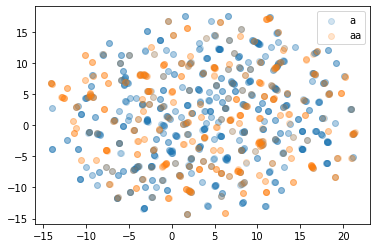

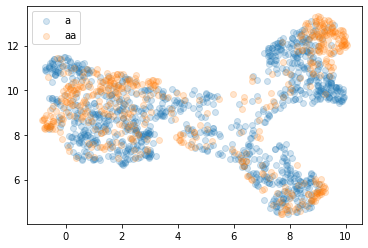

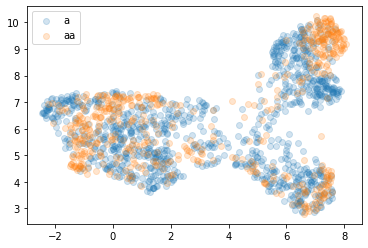

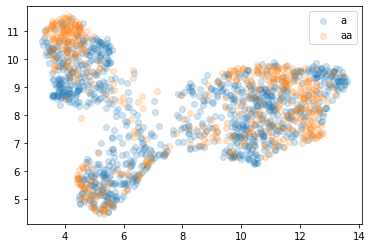

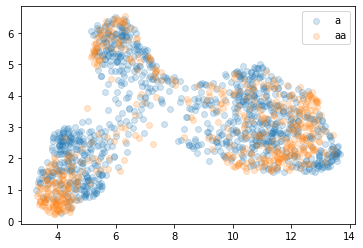

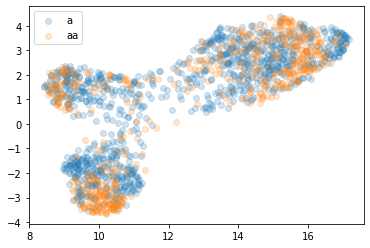

In [ ]:
#set the n neighbors
for n_neighbors in [2, 20, 50, 100, 200, 500]:
    #min dist: quite tight clusters
    #the umap object is from the umap libraries not from sklearn, but call with the same function
    umap = UMAP(n_neighbors=n_neighbors, min_dist=0.2, metric="euclidean", random_state=0)
    Xumap = umap.fit_transform(X_compressed)
    plot(Xumap,train_hb_y + dev_hb_y + test_hb_y)
    plt.show()